In [612]:
#import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact


#set aesthetics requirements
sns.set(style="white")
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.options.display.float_format = '{:,}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [613]:
# Reading the csv file and putting it into 'df' object.
leads = pd.read_csv('datasets_78342_179673_olist_marketing_qualified_leads_dataset.csv')
leads.head()

mql_id first_contact_date  \
0  dac32acd4db4c29c230538b72f8dd87d         2018-02-01   
1  8c18d1de7f67e60dbd64e3c07d7e9d5d         2017-10-20   
2  b4bc852d233dfefc5131f593b538befa         2018-03-22   
3  6be030b81c75970747525b843c1ef4f8         2018-01-22   
4  5420aad7fec3549a85876ba1c529bd84         2018-02-21   

                    landing_page_id          origin  
0  88740e65d5d6b056e0cda098e1ea6313          social  
1  007f9098284a86ee80ddeb25d53e0af8     paid_search  
2  a7982125ff7aa3b2054c6e44f9d28522  organic_search  
3  d45d558f0daeecf3cccdffe3c59684aa           email  
4  b48ec5f3b04e9068441002a19df93c6c  organic_search

In [614]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
mql_id                8000 non-null object
first_contact_date    8000 non-null object
landing_page_id       8000 non-null object
origin                7940 non-null object
dtypes: object(4)
memory usage: 250.1+ KB


In [615]:
leads.describe(include="all")

mql_id first_contact_date  \
count                               8000               8000   
unique                              8000                336   
top     524e7d08e755cc664226b3d4b8660cd7         2018-05-02   
freq                                   1                 93   

                         landing_page_id          origin  
count                               8000            7940  
unique                               495              10  
top     b76ef37428e6799c421989521c0e5077  organic_search  
freq                                 912            2296

In [616]:
leads.origin.value_counts()

organic_search       2296
paid_search          1586
social               1350
unknown              1099
direct_traffic        499
email                 493
referral              284
other                 150
display               118
other_publicities      65
Name: origin, dtype: int64

In [617]:
leads['origin'] = leads['origin'].fillna('unknown')

In [618]:
leads.isnull().sum(axis=0)

mql_id                0
first_contact_date    0
landing_page_id       0
origin                0
dtype: int64

In [619]:
leads.describe(include="all")

mql_id first_contact_date  \
count                               8000               8000   
unique                              8000                336   
top     524e7d08e755cc664226b3d4b8660cd7         2018-05-02   
freq                                   1                 93   

                         landing_page_id          origin  
count                               8000            8000  
unique                               495              10  
top     b76ef37428e6799c421989521c0e5077  organic_search  
freq                                 912            2296

In [620]:
leads["first_contact_date"] = leads["first_contact_date"].astype("datetime64")

In [621]:
leads['first_contact_date'] = leads['first_contact_date'].dt.to_period('M')
leads.head()

mql_id first_contact_date  \
0  dac32acd4db4c29c230538b72f8dd87d            2018-02   
1  8c18d1de7f67e60dbd64e3c07d7e9d5d            2017-10   
2  b4bc852d233dfefc5131f593b538befa            2018-03   
3  6be030b81c75970747525b843c1ef4f8            2018-01   
4  5420aad7fec3549a85876ba1c529bd84            2018-02   

                    landing_page_id          origin  
0  88740e65d5d6b056e0cda098e1ea6313          social  
1  007f9098284a86ee80ddeb25d53e0af8     paid_search  
2  a7982125ff7aa3b2054c6e44f9d28522  organic_search  
3  d45d558f0daeecf3cccdffe3c59684aa           email  
4  b48ec5f3b04e9068441002a19df93c6c  organic_search

In [622]:
closed = pd.read_csv('datasets_78342_179673_olist_closed_deals_dataset.csv')
closed.head()

mql_id                         seller_id  \
0  5420aad7fec3549a85876ba1c529bd84  2c43fb513632d29b3b58df74816f1b06   
1  a555fb36b9368110ede0f043dfc3b9a0  bbb7d7893a450660432ea6652310ebb7   
2  327174d3648a2d047e8940d7d15204ca  612170e34b97004b3ba37eae81836b4c   
3  f5fee8f7da74f4887f5bcae2bafb6dd6  21e1781e36faf92725dde4730a88ca0f   
4  ffe640179b554e295c167a2f6be528e0  ed8cb7b190ceb6067227478e48cf8dde   

                             sdr_id                             sr_id  \
0  a8387c01a09e99ce014107505b92388c  4ef15afb4b2723d8f3d81e51ec7afefe   
1  09285259593c61296eef10c734121d5b  d3d1e91a157ea7f90548eef82f1955e3   
2  b90f87164b5f8c2cfa5c8572834dbe3f  6565aa9ce3178a5caf6171827af3a9ba   
3  56bf83c4bb35763a51c2baab501b4c67  d3d1e91a157ea7f90548eef82f1955e3   
4  4b339f9567d060bcea4f5136b9f5949e  d3d1e91a157ea7f90548eef82f1955e3   

              won_date business_segment      lead_type lead_behaviour_profile  \
0  2018-02-26 19:58:54              pet  online_medium                    cat   
1  2018-05-08 20:17:59  car_accessories       industry                  eagle   
2  2018-06-05 17:27:23  home_appliances     online_big                    cat   
3  2018-01-17 13:51:03       food_drink   online_small                    NaN   
4  2018-07-03 20:17:45  home_appliances       industry                   wolf   

  has_company has_gtin average_stock business_type  \
0         NaN      NaN           NaN      reseller   
1         NaN      NaN           NaN      reseller   
2         NaN      NaN           NaN      reseller   
3         NaN      NaN           NaN      reseller   
4         NaN      NaN           NaN  manufacturer   

   declared_product_catalog_size  declared_monthly_revenue  
0                            nan                       0.0  
1                            nan                       0.0  
2                            nan                       0.0  
3                            nan                       0.0  
4                            nan                       0.0

In [623]:
closed.describe(include="all")

mql_id                         seller_id  \
count                                842                               842   
unique                               842                               842   
top     3cab34e6c6a51d1f2ca8e76908c62368  f1340f6d3347d9fae747fc3d236a2e41   
freq                                   1                                 1   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

                                  sdr_id                             sr_id  \
count                                842                               842   
unique                                32                                22   
top     4b339f9567d060bcea4f5136b9f5949e  4ef15afb4b2723d8f3d81e51ec7afefe   
freq                                 140                               133   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

                   won_date business_segment      lead_type  \
count                   842              841            836   
unique                  824               33              8   
top     2018-05-04 03:00:00       home_decor  online_medium   
freq                      6              105            332   
mean                    NaN              NaN            NaN   
std                     NaN              NaN            NaN   
min                     NaN              NaN            NaN   
25%                     NaN              NaN            NaN   
50%                     NaN              NaN            NaN   
75%                     NaN              NaN            NaN   
max                     NaN              NaN            NaN   

       lead_behaviour_profile has_company has_gtin average_stock  \
count                     665          63       64            66   
unique                      9           2        2             6   
top                       cat        True     True          5-20   
freq                      407          58       54            22   
mean                      NaN         NaN      NaN           NaN   
std                       NaN         NaN      NaN           NaN   
min                       NaN         NaN      NaN           NaN   
25%                       NaN         NaN      NaN           NaN   
50%                       NaN         NaN      NaN           NaN   
75%                       NaN         NaN      NaN           NaN   
max                       NaN         NaN      NaN           NaN   

       business_type  declared_product_catalog_size  declared_monthly_revenue  
count            832                           69.0                     842.0  
unique             3                            nan                       nan  
top         reseller                            nan                       nan  
freq             587                            nan                       nan  
mean             NaN             233.02898550724638        73,377.67933491686  
std              NaN             352.38055844642514      1,744,799.1768914168  
min              NaN      

In [624]:
closed = closed[['mql_id', 'seller_id']]
closed.head()

mql_id                         seller_id
0  5420aad7fec3549a85876ba1c529bd84  2c43fb513632d29b3b58df74816f1b06
1  a555fb36b9368110ede0f043dfc3b9a0  bbb7d7893a450660432ea6652310ebb7
2  327174d3648a2d047e8940d7d15204ca  612170e34b97004b3ba37eae81836b4c
3  f5fee8f7da74f4887f5bcae2bafb6dd6  21e1781e36faf92725dde4730a88ca0f
4  ffe640179b554e295c167a2f6be528e0  ed8cb7b190ceb6067227478e48cf8dde

In [625]:
data = pd.merge(leads,
                  closed,
                  how='left',
                  on='mql_id')
data.head()

mql_id first_contact_date  \
0  dac32acd4db4c29c230538b72f8dd87d            2018-02   
1  8c18d1de7f67e60dbd64e3c07d7e9d5d            2017-10   
2  b4bc852d233dfefc5131f593b538befa            2018-03   
3  6be030b81c75970747525b843c1ef4f8            2018-01   
4  5420aad7fec3549a85876ba1c529bd84            2018-02   

                    landing_page_id          origin  \
0  88740e65d5d6b056e0cda098e1ea6313          social   
1  007f9098284a86ee80ddeb25d53e0af8     paid_search   
2  a7982125ff7aa3b2054c6e44f9d28522  organic_search   
3  d45d558f0daeecf3cccdffe3c59684aa           email   
4  b48ec5f3b04e9068441002a19df93c6c  organic_search   

                          seller_id  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4  2c43fb513632d29b3b58df74816f1b06

In [626]:
data['seller_id'] = data['seller_id'].fillna(0)
data['seller_id'] = data['seller_id'].apply(lambda x: 1 if x else 0)
data.head()

mql_id first_contact_date  \
0  dac32acd4db4c29c230538b72f8dd87d            2018-02   
1  8c18d1de7f67e60dbd64e3c07d7e9d5d            2017-10   
2  b4bc852d233dfefc5131f593b538befa            2018-03   
3  6be030b81c75970747525b843c1ef4f8            2018-01   
4  5420aad7fec3549a85876ba1c529bd84            2018-02   

                    landing_page_id          origin  seller_id  
0  88740e65d5d6b056e0cda098e1ea6313          social          0  
1  007f9098284a86ee80ddeb25d53e0af8     paid_search          0  
2  a7982125ff7aa3b2054c6e44f9d28522  organic_search          0  
3  d45d558f0daeecf3cccdffe3c59684aa           email          0  
4  b48ec5f3b04e9068441002a19df93c6c  organic_search          1

In [627]:
monthly_conversion = data.groupby(by='first_contact_date')['seller_id'].agg(['count', 'sum'])
monthly_conversion['conversion_rate(%)'] = ((monthly_conversion['sum'] / monthly_conversion['count']) * 100).round(1)
monthly_conversion

count  sum  conversion_rate(%)
first_contact_date                                
2017-06                 4    0                 0.0
2017-07               239    2                 0.8
2017-08               386    9                 2.3
2017-09               312    7                 2.2
2017-10               416   14                 3.4
2017-11               445   18                 4.0
2017-12               200   11                 5.5
2018-01              1141  152                13.3
2018-02              1028  149                14.5
2018-03              1174  167                14.2
2018-04              1352  183                13.5
2018-05              1303  130                10.0

Text(0.5, 1.0, 'Conversion Rate (Jun 2017 - May 2018)')

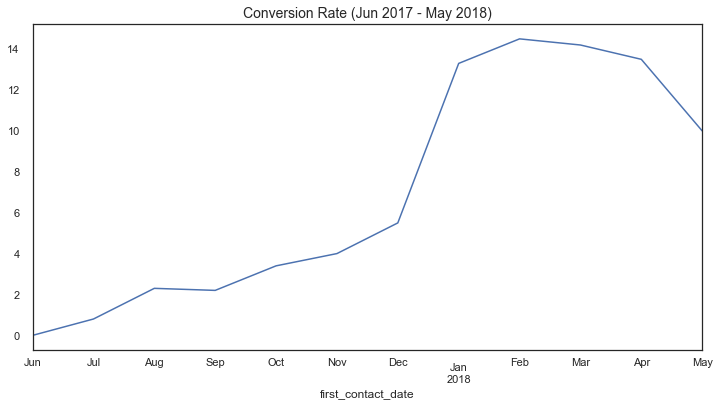

In [628]:
# Plot the monthly conversion rate
monthly_conversion['conversion_rate(%)'].plot.line(figsize=(12, 6))
plt.title('Conversion Rate (Jun 2017 - May 2018)', fontsize=14)

### There is no seasonality is converion. Company is improving lead generation and conversion over time. Hence contact date is not useful to predict if lead will get converted. 

In [629]:
data.drop('first_contact_date', axis=1, inplace = True)
data.head()

mql_id                   landing_page_id  \
0  dac32acd4db4c29c230538b72f8dd87d  88740e65d5d6b056e0cda098e1ea6313   
1  8c18d1de7f67e60dbd64e3c07d7e9d5d  007f9098284a86ee80ddeb25d53e0af8   
2  b4bc852d233dfefc5131f593b538befa  a7982125ff7aa3b2054c6e44f9d28522   
3  6be030b81c75970747525b843c1ef4f8  d45d558f0daeecf3cccdffe3c59684aa   
4  5420aad7fec3549a85876ba1c529bd84  b48ec5f3b04e9068441002a19df93c6c   

           origin  seller_id  
0          social          0  
1     paid_search          0  
2  organic_search          0  
3           email          0  
4  organic_search          1

In [630]:
dist = data.groupby(['landing_page_id', 'origin'],  as_index=False).mql_id.count()
dist.to_csv (r'train_distribution.csv', index = False, header=True)

In [631]:
landing_page_id_list = pd.DataFrame(data.landing_page_id.unique())
landing_page_id_list.to_csv (r'landing_page_id_list.csv', index = False, header=True)

In [632]:
origin_list = pd.DataFrame(data.origin.unique())
origin_list.to_csv (r'origin_list.csv', index = False, header=True)

### MLflow setup

In [634]:
with mlflow.start_run():
    encoder_landing_page_id = preprocessing.LabelEncoder()
    encoder_landing_page_id.fit(data['landing_page_id'])
    data['landing_page_id'] = encoder_landing_page_id.transform(data['landing_page_id'])

    encoder_origin = preprocessing.LabelEncoder()
    encoder_origin.fit(data['origin'])
    data['origin'] = encoder_origin.transform(data['origin'])
    
    # Log encoder model to MLflow    
    mlflow.set_tag('Stage', 'Data preporcessing') 
    mlflow.sklearn.log_model(encoder_landing_page_id, "encoder_landing_page_id")
    mlflow.sklearn.log_model(encoder_origin, "encoder_origin")
    mlflow.log_artifact('train_distribution.csv')
    mlflow.log_artifact('landing_page_id_list.csv')
    mlflow.log_artifact('origin_list.csv')

data.head()

MlflowException: Could not create run under non-active experiment with ID 1.

In [ ]:
encoder_origin.transform(pd.DataFrame(['social']))

In [ ]:
X = data[['landing_page_id', 'origin']]
y = data['seller_id']

In [ ]:
X.head()

In [ ]:
y.head()

### 80% train, 30% test

In [ ]:
# Splitting the data into train and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [ ]:
print(X_train.info())
X_train.to_csv (r'X_train.csv', index = False, header=True)
y_train.to_csv (r'y_train.csv', index = False, header=True)
X_test.to_csv (r'X_test.csv', index = False, header=True)
y_test.to_csv (r'y_test.csv', index = False, header=True)

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
print(X_train.info())
print(y_train.info())

In [ ]:
#print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
#print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
  


In [ ]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_res,y_train_res)

In [ ]:
# Making predictions
predictions = rfc.predict(X_train_res)

# Let's check the report of our default model
print(classification_report(y_train_res,predictions))

# Making predictions
predictions = rfc.predict(X_test)

# Let's check the report of our default model
print(classification_report(y_test,predictions))

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'min_samples_split': range(2, 10, 2),
    'n_estimators': [10, 50, 100]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring="recall",
                          cv = 3, n_jobs = -1,verbose = 1)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)

In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get recall of',grid_search.best_score_,'using',grid_search.best_params_)

with mlflow.start_run():
    mlflow.set_tag('Stage', 'Hyperparameter Tuning') 
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("recall", grid_search.best_score_)

In [ ]:
rfc = RandomForestClassifier(min_samples_split=2, n_estimators=50, random_state=42)
# fit
rfc.fit(X_train_res,y_train_res)

In [ ]:
#validation

# Making predictions
predictions = rfc.predict(X_test)

# Let's check the report of our default model
print(classification_report(y_test,predictions))

In [ ]:
with mlflow.start_run():
    mlflow.set_tag('Stage', 'Validation') 
    mlflow.log_param("min_samples_split", 2)
    mlflow.log_param("n_estimators", 50)
    mlflow.sklearn.log_model(rfc, "RandonForest")
    mlflow.log_metric("recall", classification_report(y_test,predictions,output_dict=True)['1']['recall'])
    mlflow.log_metric("precision", classification_report(y_test,predictions,output_dict=True)['1']['precision'])

In [ ]:
sm = SMOTE(random_state = 2) 
X_res, y_res = sm.fit_sample(X, y.ravel())

rfc = RandomForestClassifier(min_samples_split=2, n_estimators=50, random_state=42)
# fit
rfc.fit(X_res,y_res)

In [ ]:
predictions = rfc.predict(X_res)

# Let's check the report of our default model
print(classification_report(y_res,predictions))

In [ ]:
with mlflow.start_run(runName = 'Test'):
    mlflow.set_experiment('LeadPred')
    mlflow.set_tag('Stage', 'Training') 
    mlflow.log_param("min_samples_split", 2)
    mlflow.log_param("n_estimators", 50)
    mlflow.sklearn.log_model(rfc, "RandonForest")
    mlflow.log_metric("recall", classification_report(y_res,predictions,output_dict=True)['1']['recall'])
    mlflow.log_metric("precision", classification_report(y_res,predictions,output_dict=True)['1']['precision'])

In [ ]:
dist = data.groupby(['landing_page_id', 'origin'],  as_index=False).mql_id.count()
sum(dist.mql_id == 1)

### There are lot of combinations (~60%) that are there just once and hence there is a big differcence in cross validation and test results

### Load Model

In [ ]:
model = mlflow.sklearn.load_model('mlruns/0/dbade588f1f44c5db2427ae03ad95ad5/artifacts/RandonForest')

In [ ]:
predictions = model.predict(X_res)
print(classification_report(y_res,predictions))
